In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',version=1)
mnist.keys()

c:\Users\amgad\anaconda3\Lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

 So it is a 70000 data point with 784 feature each

In [16]:
import numpy as np
x,y = mnist['data'] , mnist['target']
# print(x.shape,y.shape)
y = y.astype(np.uint8)

In [17]:
#split test and train
x_train , x_test , y_train , y_test = x[:60000] , x[60000:] , y[:60000] , y[60000:]

# To make it Binary Classification we will classify just if it is 5 or not

In [18]:
#this will make the values in y_train_5 and y_test_5 zero or one
y_train_5 = (y_train == 5)
y_test_5 = (y_test==5)

In [24]:
#We will use stochastic classifier cause it is good with large dataset but any other classifier will work ok
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(x_train, y_train_5)

SGDClassifier(random_state=42)

In [25]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,x_train,y_train_5,cv=3,scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

# After fitting the model we got a 95% accuracy but let's make a dumb classifier to see if it's really good classifier or it is just luck beacuse fo data
in dumb classifier we will just classifies every single image in the "not_5" class which means any data point i will say it is not 5 even if it is 5

In [26]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, x, y=None):
        pass
    def predict(self, x):
        return np.zeros((len(x), 1), dtype=bool)

# We got 90% accuracy and this is because the data is imbalanced all the data is not 5 except 10%

In [27]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, x_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

# The first mertic to measure performance is The Confusion Matrix

In [28]:
# Just like the cross_val_score() function, cross_val_predict() performs K-fold
# cross-validation, but instead of returning the evaluation scores, it returns the predic‐tions made on each test fold. 
# This means that you get a clean prediction for each instance in the training set (“clean” meaning that the prediction is made by a model that never saw the data during training).
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3)

The resulted array represents the TN = 53892 , FP = 687 , FN = 1891 , TP = 3530 

In [29]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [30]:
#To see what the perfect Confusion matrix should looklike
y_train_perfect_predictions = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

# Precision and Recall
Scikit-Learn provides several functions to compute classifier metrics, including precision and recall.
And now we see how the performance drops it's not 95% as it was because the data is imbalanced

In [32]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # precision = TP / (TP+FP) = 3530 / (3530+687)

0.8370879772350012

In [33]:
recall_score(y_train_5, y_train_pred) # recall = TP / (TP+FN) = 3530 / (3530+1891)

0.6511713705958311

In [34]:
#It is often convenient to combine precision and recall into a single metric called the F1 score, in particular if you need a simple way to compare two classifiers. The F1 score is the harmonic mean of precision and recall
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [37]:
#The decision_function that specifies the proper threshold uses a kind of a score for every picture 
y_scores = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3,method="decision_function")

In [38]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Notice that the precision might decrease as the threshold increase

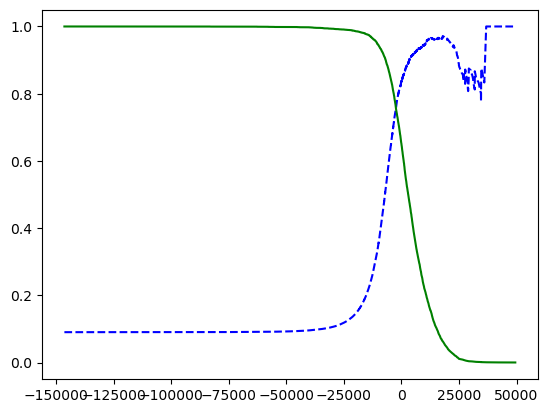

In [39]:
import matplotlib as mpl
import matplotlib.pyplot as plt
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

# ROC Curve

In [40]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

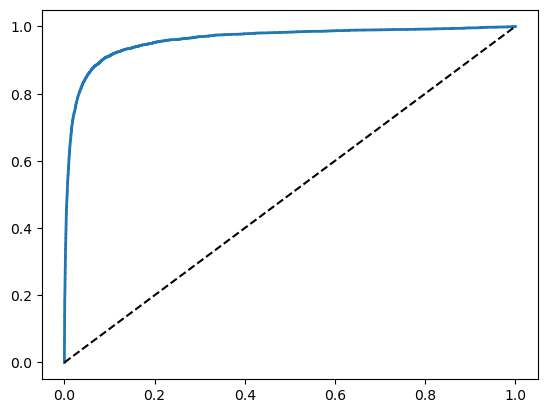

In [41]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
plot_roc_curve(fpr, tpr)
plt.show()

In [42]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Since the ROC curve is so similar to the precision/recall (or PR)
curve, you may wonder how to decide which one to use. As a rule
of thumb, you should prefer the PR curve whenever the positive
class is rare or when you care more about the false positives than
the false negatives, and the ROC curve otherwise. For example,
looking at the previous ROC curve (and the ROC AUC score), you
may think that the classifier is really good. But this is mostly
because there are few positives (5s) compared to the negatives
(non-5s). In contrast, the PR curve makes it clear that the classifier
has room for improvement (the curve could be closer to the topright
corner).